# Latitudinal Biomass Gradient

In [1]:
from cgeniepy.foram import ForamModel as fm
from matplotlib import pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cgeniepy.grid import GENIE_lat
import pandas as pd
import numpy as np
import seaborn as sns
from cgeniepy.plot import genie_cmap
import matplotlib.transforms as mtransforms

# `rm ~/.matplotlib/fontlist-v330.json` if can't find font
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["font.family"] = "Fira Sans"
my_cmap = genie_cmap("parula")

def new_axis_right(ax):
    divider = make_axes_locatable(ax)
    ax_right = divider.new_horizontal(size="30%", pad=0.5, axes_class=plt.Axes)
    ax_right.grid(True, which='both', linestyle='--', linewidth=0.3)
    for position in ['top','bottom','left','right']:
        ax_right.spines[position].set_linewidth(0.5)

    ax_right.set_xlim([0, 0.25])
    return ax_right

/Users/yingrui/cgeniepy/src/cgeniepy/core.py:239: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.pure_array(), *args, **kwargs)
/Users/yingrui/cgeniepy/src/cgeniepy/core.py:239: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.pure_array(), *args, **kwargs)


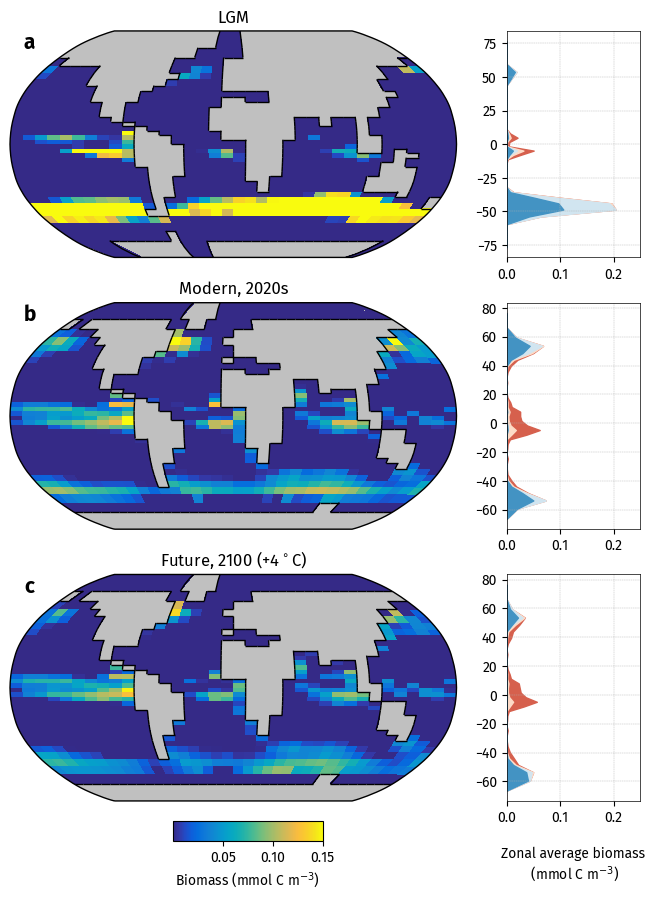

In [2]:
## Init figure and axes
fig = plt.figure(figsize=(10, 10))
trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)

ax1 = fig.add_subplot(311, projection=ccrs.Robinson())
ax1r = new_axis_right(ax1)
fig.add_axes(ax1r)

ax2 = fig.add_subplot(312, projection=ccrs.Robinson())
ax2r = new_axis_right(ax2)
fig.add_axes(ax2r)

ax3 = fig.add_subplot(313, projection=ccrs.Robinson())
ax3r = new_axis_right(ax3)
fig.add_axes(ax3r)

ax3r.set_xlabel("\n"
                r"Zonal average biomass"
                "\n"
                r" (mmol C m$^{-3}$)")


## plot latitudinal biomass gradient
def plot_lbg(model_path, ax_main, ax_side, label="", title="", time=-1):
    ax_main.text(0, 0.95, label, transform=ax_main.transAxes + trans, weight="bold", fontsize=15)
    ax_main.set_title(title)
    model = fm(model_path)
    p = model.select_foramtype(["bn", "bs","sn","ss"]).biomass(combine_vars=True).take(-1, axis=0).plot_map(ax=ax_main, colorbar=False, cmap=my_cmap, vmax=0.15)
    bn = model.select_foramtype("bn").biomass().isel(time=time).nanmean(axis=1)
    bs = model.select_foramtype("bs").biomass().isel(time=time).nanmean(axis=1)
    sn = model.select_foramtype("sn").biomass().isel(time=time).nanmean(axis=1)
    ss = model.select_foramtype("ss").biomass().isel(time=time).nanmean(axis=1)
    lat = GENIE_lat()
    df = pd.DataFrame(data=np.array([bn, bs, sn, ss]).T, index=np.array(lat).T,
                      columns = ["Symbiont-barren Non-spinose",
                                 "Symbiont-barrn Spinose", "Symbiont-facultative non-spinose", "Symbiont-obligate spinose"])
    df.index.name='Latitude'
    data = np.cumsum(df.values, axis=1)
    clist = sns.color_palette("RdBu_r", 4).as_hex()
    for i, col in enumerate(df.columns):
        ax_side.fill_betweenx(df.index, data[:,i], label=col, zorder=-i, color=clist[i])
    return p

# Don't use the first year because the model isn't in equilibrium with lack of restart coding

plot_lbg("../model/muffin.CB.GIteiiva.BASESFeTDTL_rb_foramecogem2.1", ax1, ax1r, label="a", title="LGM")
plot_lbg("../model/worjh2.RpCO2_Rp13CO2.Albani.0ka.historical", ax2, ax2r, label="b", title="Modern, 2020s")
p =plot_lbg("../model/worjh2.RpCO2_Rp13CO2.Albani.2100.4deg", ax3, ax3r, label="c",time=-1, title=r"Future, 2100 (+4$^\circ$C)")

cax = fig.add_axes([0.36, 0.07, 0.15, 0.02])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal',  fraction=0.05)
cbar.set_label(r"Biomass (mmol C m$^{-3}$)", fontsize=10)

fig.savefig("../output/total_biomass_change.png", dpi=400, bbox_inches='tight')